In [34]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.colors as mplc
from matplotlib import cm
import matplotlib.patches as mpatches
import json 
import pickle
import yaml
from matplotlib.lines import Line2D
from unidecode import unidecode

from utils import legends 

with open("configs/config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [35]:
region_name = config['region_name'] #if country is studied, then use country name
region_name_clean = unidecode(region_name)
region_name_clean = region_name_clean.replace(" ", "")
region_name_clean = region_name_clean.replace(".", "")
region_name_clean = region_name_clean.replace("'", "") 
region_name = region_name_clean
region_folder_name = config['region_folder_name']

resampled = '_resampled'  

if config['landcover_source'] == 'openeo':
        landcover_source = 'esa_worldcover2021' #copernicus_global_coll3  Corine_Europe_2012  esa_worldcover2021
elif config['landcover_source'] == 'file':
        landcover_source = 'copernicus_global_coll3'

colors_dict = getattr(legends, 'colors_dict_' + landcover_source)
colors_dict_int = getattr(legends, 'colors_dict_' + landcover_source + '_int') #color codes as RGB integers
legend_dict = getattr(legends, 'legend_dict_' + landcover_source)

# Get path to this file and then also path to data
dirname = os.getcwd()
data_path = os.path.join(dirname, 'data', region_folder_name)
data_path2 = os.path.join(dirname, 'data', region_folder_name, 'derived_from_DEM')
with open(os.path.join(data_path, region_name+'_EPSG.pkl'), 'rb') as file:
        EPSG = pickle.load(file)

####
#EPSG=3035
####

print(f'EPSG {EPSG}')

landcoverRasterPath = os.path.join(data_path, f'landcover_{region_name}_EPSG{EPSG}.tif')
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_EPSG{EPSG}{resampled}.tif')
slopeRasterPath = os.path.join(data_path2, f'slope_{region_name}_EPSG{EPSG}{resampled}.tif')
aspectRasterPath = os.path.join(data_path2, f'aspect_{region_name}_EPSG{EPSG}{resampled}.tif')
regionPath = os.path.join(data_path, f'{region_name}_{EPSG}.geojson')
region_boundary = gpd.read_file(regionPath)

EPSG 32650


# Roads, Railways, Airports (& Transmission lines)

region geojson loaded EPSG: EPSG:32650
c:\Users\b076218\Documents\Filkassen\China - modeling\EDO\RE spatial planning\LAVA_Kina\data\Beijing


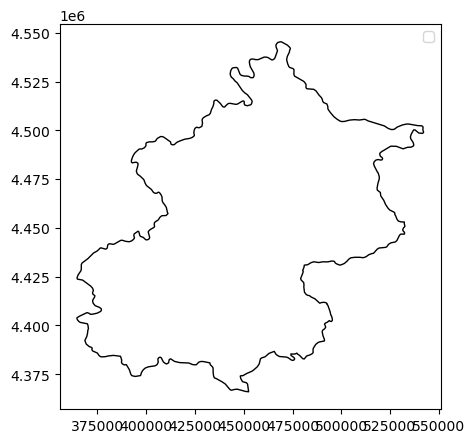

In [36]:
region_boundary = gpd.read_file(regionPath)
print(f'region geojson loaded EPSG: {region_boundary.crs}')
print(data_path)

fig, ax = plt.subplots(figsize=(5, 5))
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1, label='region boundary')

# Create custom legend handles because lines and polygons are displayed
handles = [] #Line2D([0], [0], color='black', lw=1, label='region boundary')

try:
    OSM_roads = gpd.read_file(os.path.join(data_path, f'OSM_roads_{region_name}_{EPSG}.gpkg'))
    OSM_roads.plot(ax=ax, label='roads', linewidth=0.3, color = 'deepskyblue')
    handles.append(Line2D([0], [0], color='deepskyblue', lw=1, label='roads'))
except:
    pass 
try:
    OSM_railways = gpd.read_file(os.path.join(data_path, f'OSM_railways_{region_name}_{EPSG}.gpkg'))
    OSM_railways.plot(ax=ax, label='railways', color = 'brown')
    handles.append(Line2D([0], [0], color='brown', lw=2, label='railways'))
except:
    pass
try:
    OSM_airpots = gpd.read_file(os.path.join(data_path, f'OSM_airports_{region_name}_{EPSG}.gpkg'))
    OSM_airpots.plot(ax=ax, label='airport', color = 'red')
    handles.append(Line2D([0], [0], color='red', lw=2, label='airport'))
except:
    pass
try:
    OSM_military = gpd.read_file(os.path.join(data_path, f'OSM_military_{region_name}_{EPSG}.gpkg'))
    OSM_airpots.plot(ax=ax, label='military', color = 'darkgreen')
    handles.append(Line2D([0], [0], color='darkgreen', lw=2, label='military area'))
except:
    pass


#ax.legend()

# Add legend using custom handles
ax.legend(handles=handles)

# Landcover Analysis

In [39]:
#save pixel size EPSG 4326
with rasterio.open(os.path.join(data_path, f'DEM_{region_name}_EPSG32650.tif')) as src:
    res = src.transform[0] #pixel size

    with open(os.path.join(data_path, f'pixel_size_DEM_{region_name}_32650.json'), 'w') as fp:
        json.dump(res, fp)

RasterioIOError: c:/Users/b076218/Documents/Filkassen/China - modeling/EDO/RE spatial planning/LAVA_Kina/data/Beijing/DEM_Beijing_EPSG32650.tif: No such file or directory

In [ ]:
#inspect land cover data
landcover = rasterio.open(landcoverRasterPath) 

band = landcover.read(1, masked=True) #masked=True is masking no data values
meta = landcover.meta
print(f'landcover EPSG: {landcover.crs}')
print(f'bands (number of layers): {landcover.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')
res = landcover.transform[0] #pixel size
#save pixel size local CRS
with open(os.path.join(data_path, f'pixel_size_{region_name}_{EPSG}.json'), 'w') as fp:
    json.dump(res, fp)


#save landcover transform
with open(os.path.join(data_path, f'transform_landcover_{region_name}_{EPSG}.json'), 'w') as f:
    json.dump(landcover.transform, f)

print(f'pixel size: {res}')


print(landcover.tags(1))

band

landcover EPSG: EPSG:32633
bands (number of layers): 1
band shape: (28807, 27119)
number of Pixels: 781217033
pixel size: 8.11726460891206
{}


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint8)

In [6]:
landcover.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 27119, 'height': 28807, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(8.11726460891206, 0.0, 200474.74661961664,
       0.0, -8.117264608912052, 4749127.961232136), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
#Available land cover codes
landuses = np.unique(band.data).tolist()

print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', landcover.meta['nodata'])

#save landuses as json file
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'w') as fp:
    json.dump(landuses, fp)

landuses

the minimum raster value is:  10
the maximum raster value is:  90
nodata value:  0.0


[0, 10, 20, 30, 40, 50, 60, 80, 90]

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'code': landuses,
    'value': [legend_dict.get(code, 'Not Found') for code in landuses],
    'area (sq km)': ''
})

#add area for each landuse
for index in range(len(df)):
    value = df.at[index,'code']
    #count pixels
    number_pixels = np.count_nonzero(band == value)
    #calculate area
    area = number_pixels * res*res / 1e6
    #save in df
    df.at[index, 'area (sq km)'] = area

no_data_area = df.loc[df['code'] == landcover.meta['nodata'], 'area (sq km)'].iloc[0]
print('total area (sqkm): ' + str(df['area (sq km)'].sum() - no_data_area))

df.to_excel(os.path.join(data_path, 'landcover_areas.xlsx'), index=False)
df

total area (sqkm): 17235.025228360693


ModuleNotFoundError: No module named 'openpyxl'

In [10]:
#save colored landcover
colors_dict_int_sorted = dict(sorted(colors_dict_int.items())) #can only write color values as int with rasterio 

meta.update({
    'compress': 'DEFLATE'  # You can also try 'DEFLATE', 'JPEG', or 'PACKBITS'
})

with rasterio.open(os.path.join(data_path, f'landcover_colored_{region_name}_EPSG{EPSG}.tif'), 'w', **meta) as dst:
    dst.write(band, indexes=1)
    dst.write_colormap(1, colors_dict_int_sorted) #be aware of dtype: landcover file is saved with int16, so RGB color values also needs to be an integer?
 
#    cmap = dst.colormap(1)

{10: 'Tree cover', 20: 'Shrubland', 30: 'Grassland', 40: 'Cropland', 50: 'Built-up', 60: 'Bare / sparse vegetation', 70: 'Snow and Ice', 80: 'Permanent water bodies', 90: 'Herbaceous wetland', 95: 'Mangroves', 100: 'Moss and lichen'}


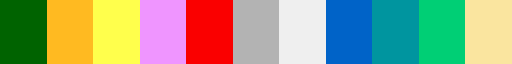

In [11]:
# sort dict and Define your unevenly spaced numbers and corresponding colors
colors_dict_sorted = dict(sorted(colors_dict.items())) #cmap only with RBG floats possible apparently
landcovercodes = list(colors_dict_sorted.keys())
colors = list(colors_dict_sorted.values())

# Create the colormap
#cmap1 = LinearSegmentedColormap.from_list("custom", list(zip(np.linspace(0, 1, len(colors)), colors)))
#cmap1 = LinearSegmentedColormap.from_list("custom", colors, N=len(colors))
cmap1 = ListedColormap(colors) #https://stackoverflow.com/questions/32766062/how-to-determine-the-colours-when-using-matplotlib-pyplot-imshow

# Create the norm to map your numbers to colors
norm = BoundaryNorm(landcovercodes, cmap1.N)

legend_dict = dict(sorted(legend_dict.items()))
print(legend_dict)
cmap1

In [11]:
#trying interactive plotting

# import xarray
# import hvplot.xarray
# import rioxarray
# import cartopy.crs as ccrs 
# import hvplot

# xds = rioxarray.open_rasterio(landcoverRasterPath)
# xds.sel(band=1).hvplot.quadmesh(
#     cmap='Greys_r', rasterize=True, data_aspect=1)

# ##crs=ccrs.epsg(EPSG), projection=ccrs.epsg(EPSG),

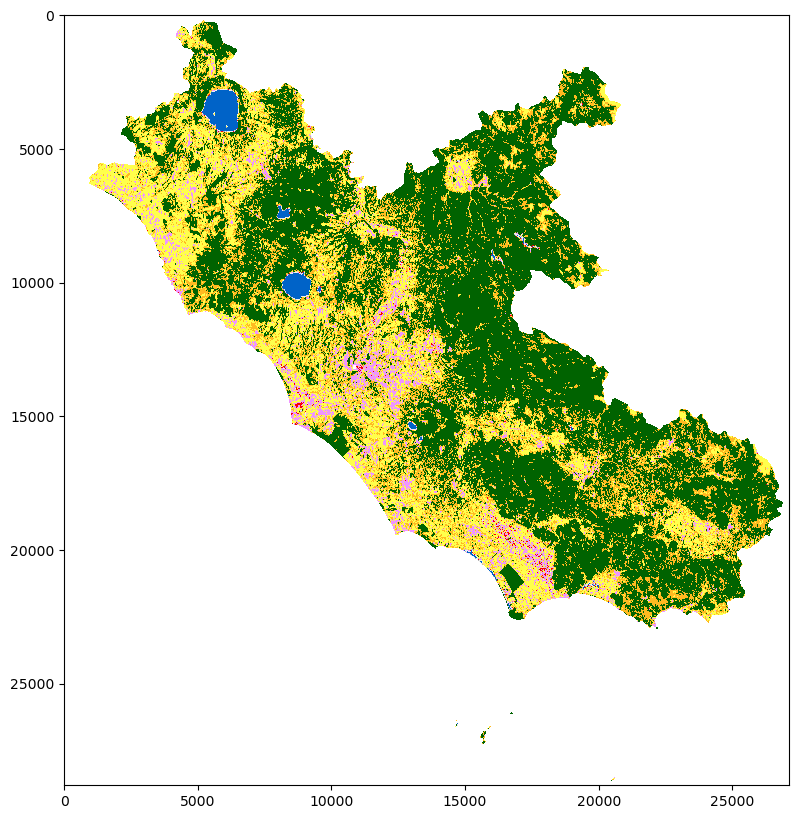

<Axes: >

In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
show(band, cmap=cmap1, norm=norm) #, cmap=landcover_cmap, vmin=20, vmax=len(colors))

#be careful with the coloring, it is not necessarily correct, there also might be some errors due to pixel size and coloring

In [14]:
band.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
def plot_single_landuse(land_use_code, band, ax):
    # Create the mask where values not equal to land use code are masked (i.e., set to True)
    mask = (band != land_use_code)
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    # Create a colormap with only one color
    color=colors_dict[land_use_code]
    cmap1 = LinearSegmentedColormap.from_list('custom_colormap', [color, color])

    show(masked_band, ax=ax, cmap=cmap1, norm=norm, transform = landcover.transform)
    ax.set_title(f'land use: {land_use_code} - ' + legend_dict[land_use_code])

    ax.ticklabel_format(axis='both', style='scientific', scilimits=(1,3))

    # Count the number of pixels with the specific value
    num_pixels = np.count_nonzero(masked_band == land_use_code)
    #print(f'eligbible cells: {num_pixels}')
    print(f'area: {round((num_pixels*res*res)/1e6,2)} km²')
    #print(masked_band.sum())




def plot_multiple_landuses(land_use_codes, band, ax, legend=False):
    # Create the mask where values not in land use codes are masked
    mask = ~np.isin(band, land_use_codes)
    
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    # Plot the masked band
    show(masked_band, ax=ax, cmap=cmap1, norm=norm, transform=landcover.transform)
    ax.set_title(f'Land uses: {", ".join(map(str, land_use_codes))}')

    ax.ticklabel_format(axis='both', style='scientific', scilimits=(1,3))

    if legend==True:
        # Create legend
        legend_patches = []
        for code in land_use_codes:
            color = cmap1(norm(code))
            name =  legend_dict[code]  # Use dict name or fallback
            patch = mpatches.Patch(color=color, label=f'{code}: {name}')
            legend_patches.append(patch)

        fig.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 0))


area: 993.45 km²


<Axes: title={'center': 'land use: 50 - Built-up'}>

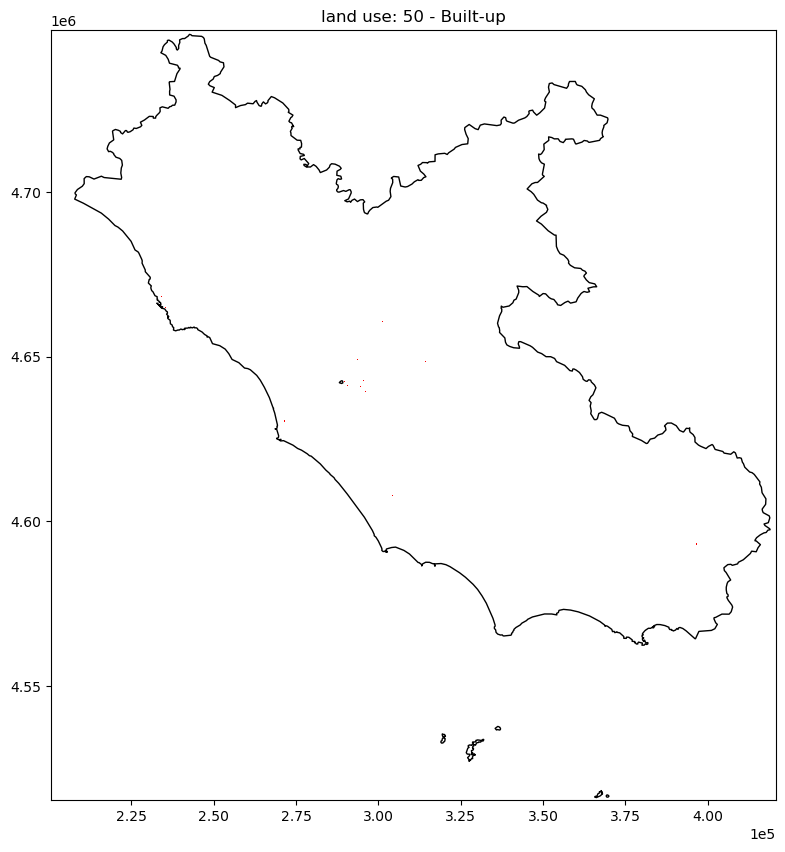

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_single_landuse(50,band,ax)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)
#make figuresize bigger if not all pixels displayed

<Axes: title={'center': 'Land uses: 50, 80'}>

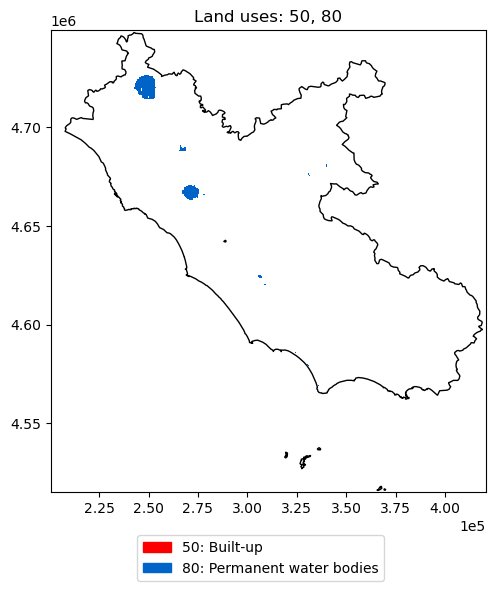

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_multiple_landuses([50,80],band,ax, legend=True)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)


In [19]:
landcover.close()

# DEM

In [ ]:
#inspect DEM data
dem = rasterio.open(demRasterPath)#, masked=True, nodata=-32767.0) #masked=True is masking no data values --> does not work

band = dem.read(1, masked=True)
print(f'raster EPSG: {dem.crs}')
print(f'bands (number of layers): {dem.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = dem.transform[0] #pixel size
print(f'pixel size: {res}')

print(dem.tags(1))

band 

raster EPSG: EPSG:32633
bands (number of layers): 1
band shape: (28807, 27119)
number of cells: 781217033
pixel size: 8.117264608912055
{}


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999,
  dtype=int16)

In [ ]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', dem.meta['nodata'])

the minimum raster value is:  -45
the maximum raster value is:  2369
nodata value:  -9999.0


<Axes: >

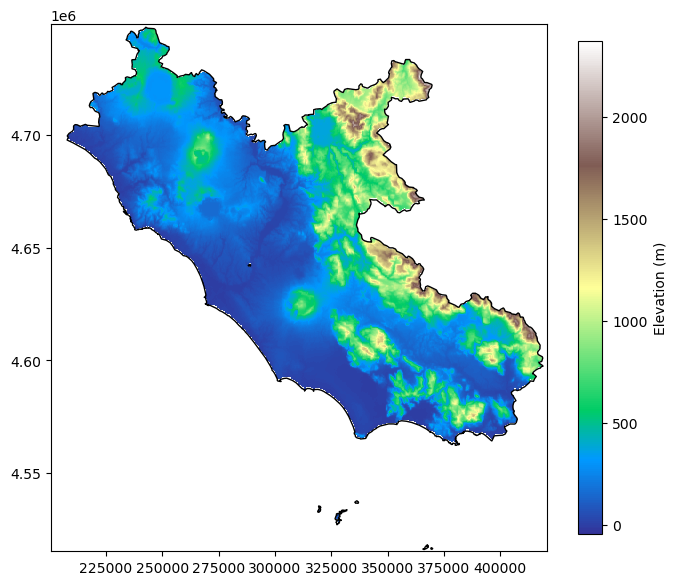

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'terrain'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Elevation (m)',shrink=0.8)

show(band, ax=ax, transform = dem.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [23]:
def plot_elevations(above_below, height, band, ax):
    if above_below == 'below':   
        # Create the mask where values higher than height are masked (i.e., set to True)
        mask = (band > height) #| (band == dem.meta['nodata'])
    if above_below == 'above':   
        # Create the mask where values lower than height are masked (i.e., set to True)
        mask = (band < height) #| (band == dem.meta['nodata'])
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))

    cmap = 'terrain'
    show(masked_band, ax=ax, transform = dem.transform, cmap=cmap, norm=norm)
    ax.set_title(f'only heights {above_below}: {height}')

    # Add colorbar
    #fig.colorbar(im, ax=ax, orientation='vertical', label='Elevation (m)')
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Elevation (m)',shrink=0.8)




<Axes: title={'center': 'only heights above: 120'}>

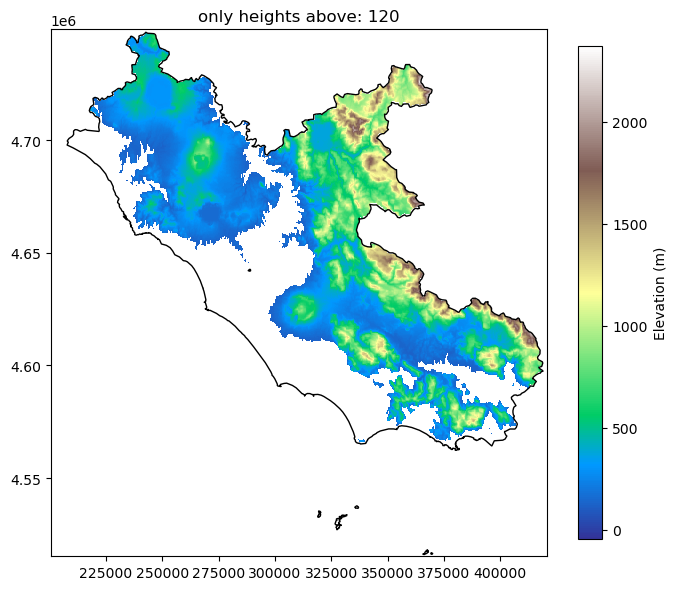

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_elevations('above', 120, band, ax)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [23]:
dem.close()

# Slope

In [ ]:
#inspect slope data
slope = rasterio.open(slopeRasterPath)#, masked=True, nodata=-32767.0) #masked=True is masking no data values --> does not work

band = slope.read(1, masked=True)
print(f'raster EPSG: {slope.crs}')
print(f'bands (number of layers): {slope.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = slope.transform[0] #pixel size
print(f'pixel size: {res}')

print(slope.tags(1))

band 

raster EPSG: EPSG:32633
bands (number of layers): 1
band shape: (28807, 27119)
number of cells: 781217033
pixel size: 8.117264608912055
{}


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999,
  dtype=int16)

In [29]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', slope.meta['nodata'])

the minimum raster value is:  0
the maximum raster value is:  36
nodata value:  -9999.0


<Axes: >

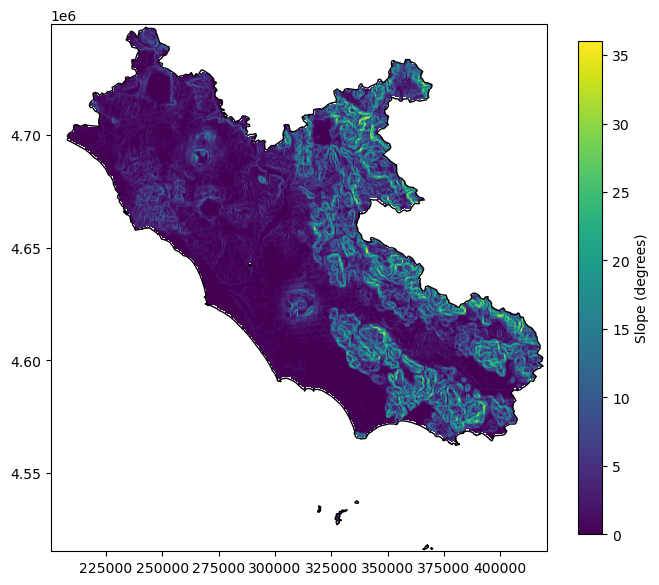

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'viridis'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Slope (degrees)',shrink=0.8)

show(band, ax=ax, transform = slope.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [27]:
slope.close()

# Aspect

In [ ]:
#inspect slope data
aspect = rasterio.open(aspectRasterPath)#, masked=True, nodata=-32767.0) #masked=True is masking no data values --> does not work

band = aspect.read(1, masked=True)
print(f'raster EPSG: {aspect.crs}')
print(f'bands (number of layers): {aspect.count}')

print(f'band shape: {band.shape}')
print(f'number of cells: {band.shape[0]*band.shape[1]}')
res = aspect.transform[0] #pixel size
print(f'pixel size: {res}')

print(aspect.tags(1))

raster EPSG: EPSG:32633
bands (number of layers): 1
band shape: (28807, 27119)
number of cells: 781217033
pixel size: 8.117264608912055
{}


In [ ]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', aspect.meta['nodata'])

the minimum raster value is:  0
the maximum raster value is:  359
nodata value:  -9999.0


<Axes: >

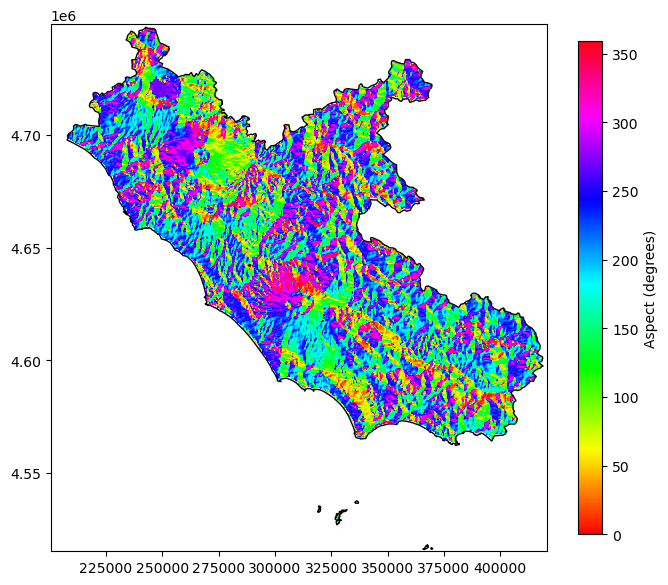

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'hsv' #hsv, twilight are a cylindrical colormap
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Aspect (degrees)',shrink=0.8)

show(band, ax=ax, transform = aspect.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

#0° represents North, 90° represents East, 180° represents South, 270° represents West

In [31]:
aspect.close()

# North facing pixels